<h1> <font color ='darkblue' size = "36px"> Restaurant location analysis</font></h1>
<h3 style="font-size : 20px"> This project aims to find a suitable location for a restaurant, while answering a few demographic questions

In [9]:
# Lets import all the libraries
import pandas as pd
import numpy as np
!conda install -c conda-forge folium --yes
import folium 
import requests
from sklearn.cluster import KMeans
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [10]:
# The code was removed by Watson Studio for sharing.

,res_id,name,establishment,url,address,city,city_id,locality,latitude,longitude,...,price_range,currency,highlights,aggregate_rating,rating_text,votes,photo_count,opentable_support,delivery,takeaway
0,3400299,Bikanervala,['Quick Bites'],https://www.zomato.com/agra/bikanervala-khanda...,"Kalyani Point, Near Tulsi Cinema, Bypass Road,...",Agra,34,Khandari,27.211450,78.002381,...,2,Rs.,"['Lunch', 'Takeaway Available', 'Credit Card',...",4.4,Very Good,814,154,0.0,-1,-1
1,3400005,Mama Chicken Mama Franky House,['Quick Bites'],https://www.zomato.com/agra/mama-chicken-mama-...,"Main Market, Sadar Bazaar, Agra Cantt, Agra",Agra,34,Agra Cantt,27.160569,78.011583,...,2,Rs.,"['Delivery', 'No Alcohol Available', 'Dinner',...",4.4,Very Good,1203,161,0.0,-1,-1
2,3401013,Bhagat Halwai,['Quick Bites'],https://www.zomato.com/agra/bhagat-halwai-2-sh...,"62/1, Near Easy Day, West Shivaji Nagar, Goalp...",Agra,34,Shahganj,27.182938,77.979684,...,1,Rs.,"['No Alcohol Available', 'Dinner', 'Takeaway A...",4.2,Very Good,801,107,0.0,1,-1
3,3400290,Bhagat Halwai,['Quick Bites'],https://www.zomato.com/agra/bhagat-halwai-civi...,"Near Anjana Cinema, Nehru Nagar, Civil Lines, ...",Agra,34,Civil Lines,27.205668,78.004799,...,1,Rs.,"['Takeaway Available', 'Credit Card', 'Lunch',...",4.3,Very Good,693,157,0.0,1,-1
4,3401744,The Salt Cafe Kitchen & Bar,['Casual Dining'],https://www.zomato.com/agra/the-salt-cafe-kitc...,"1C,3rd Floor, Fatehabad Road, Tajganj, Agra",Agra,34,Tajganj,27.157709,78.052421,...,3,Rs.,"['Lunch', 'Serves Alcohol', 'Cash', 'Credit Ca...",4.9,Excellent,470,291,0.0,1,-1


<h3>Now, out of the dataset above, we will filter the data related to New Delhi, Noida and Gurgaon only. 

In [11]:
#Getting Restaurant data for Delhi, Noida and Gurgaon
df_data_delhi = df_data[df_data['city'] == 'New Delhi']
df_data_noida = df_data[df_data['city'] == 'Noida']
df_data_gurgaon = df_data[df_data['city'] == 'Gurgaon']

#Concatinating three datasets
df_data_final=pd.concat([df_data_delhi,df_data_noida,df_data_gurgaon])
df_data_final = df_data_final.reset_index()

#Dropping columns which are not needed
df_data_final.drop(columns={'index','url','city_id','zipcode','country_id','currency'},inplace=True)

df_data_final['establishment']= df_data_final['establishment'].apply(lambda x: x.replace("[","").replace("]","").replace("'","").strip())

df_data_final['locality']= df_data_final['locality'].apply(lambda x: x.strip() if len(x.split(","))<2 else x.split(",")[1].strip() )

df_data_final['locality']= df_data_final['locality'].apply(lambda x: x.strip() if len(x.split("("))<2 else x.split("(")[0].strip() )


#Shape of the dataset
df_data_final.head()

,res_id,name,establishment,address,city,locality,latitude,longitude,locality_verbose,cuisines,...,average_cost_for_two,price_range,highlights,aggregate_rating,rating_text,votes,photo_count,opentable_support,delivery,takeaway
0,18895645,Plum By Bent Chair,Casual Dining,"The Walk, Worldmark 2, Aerocity, New Delhi",New Delhi,Aerocity,28.551540,77.122704,"Aerocity, New Delhi",Asian,...,0,1,"['Debit Card', 'Dinner', 'Cash', 'Credit Card'...",4.9,Excellent,1545,4321,0.0,-1,-1
1,18429148,Pa Pa Ya,Fine Dining,"Dome, Level 4, Select Citywalk, A-3, District ...",New Delhi,Saket,28.528391,77.218611,"Select Citywalk Mall, Saket, New Delhi","Asian, Chinese, Thai, Japanese",...,2500,4,"['Credit Card', 'Debit Card', 'Lunch', 'Serves...",4.7,Excellent,3234,8344,0.0,-1,-1
2,18418277,Ministry Of Beer,Lounge,"M 44, Outer Circle, Connaught Place, New Delhi",New Delhi,Connaught Place,28.633286,77.222787,"Connaught Place, New Delhi","Continental, Italian, Asian, Momos",...,1500,3,"['Lunch', 'Credit Card', 'Dinner', 'Cash', 'De...",4.5,Excellent,3043,9984,0.0,-1,-1
3,18625812,Detroit,Bar,"F40, 2nd Floor, Inner Circle, \nConnaught Plac...",New Delhi,Connaught Place,28.631357,77.220251,"Connaught Place, New Delhi","Bar Food, Mexican, Italian",...,1500,3,"['Lunch', 'Serves Alcohol', 'Takeaway Availabl...",4.6,Excellent,1327,3255,0.0,-1,-1
4,18423151,The Darzi Bar & Kitchen,Casual Dining,"H 55, 1st Floor, Outer Circle, Connaught Place...",New Delhi,Connaught Place,28.635508,77.219096,"Connaught Place, New Delhi","North Indian, Chinese, Continental, Pizza",...,1500,3,"['Lunch', 'Serves Alcohol', 'Cash', 'Credit Ca...",4.3,Very Good,3211,9618,0.0,-1,-1


In [4]:
df_data_final['establishment'].replace(to_replace="",value="-",inplace=True)

<p style="font-size:20px"> Lets see which type of restaurants are there the most in Delhi-NCR</p>

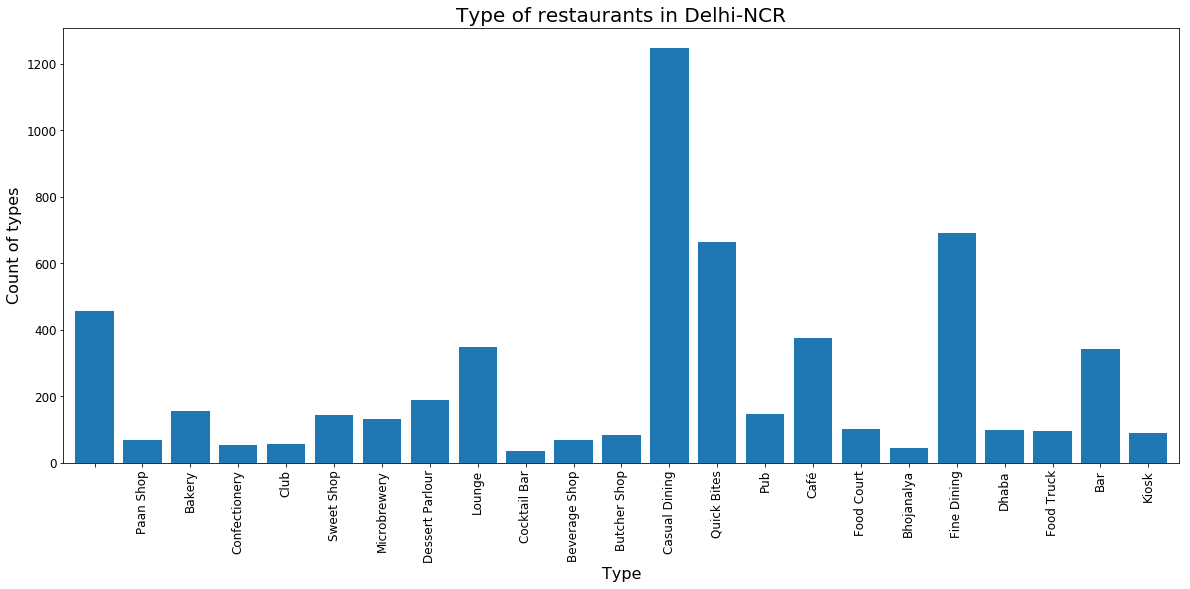

In [12]:
df_establishment=df_data_final['establishment'].value_counts(sort=False)
df_establishment.plot(kind='bar',figsize=(20,8), width=0.8)

plt.xlabel('Type',fontsize=16) # add to x-label to the plot
plt.ylabel('Count of types',fontsize=16) # add y-label to the plot
plt.title('Type of restaurants in Delhi-NCR',fontsize=20) # add title to the plot

ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

<p style="font-size:20px"> The bar graph clearly shows that there are more number of Casual Dining restaurants, followed by Fine Dining and Quick Bites

<br/>
<br/>
<p style="font-size:30px"><b> Popular Cuisines in Delhi-NCR</b></p>

<br/>
<br/>
    
<span style="font-size:20px"> First, lets see which cuisine is offered the most in Delhi-NCR

In [13]:
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

Solving environment: done

# All requested packages already installed.



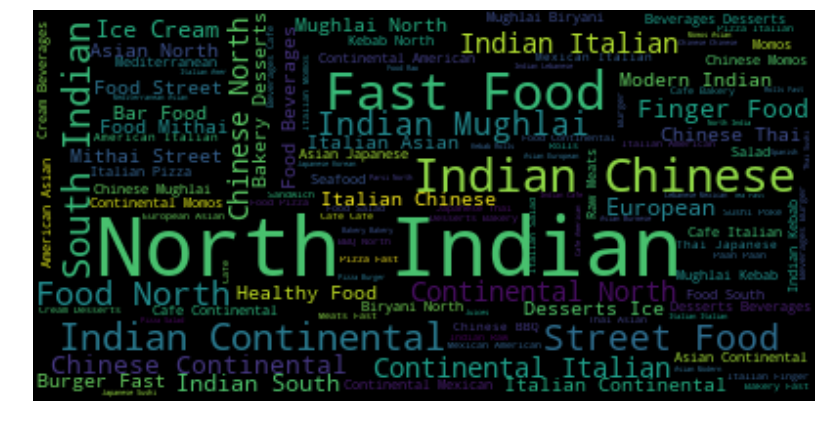

In [15]:
stopwords = set(STOPWORDS)
wc = WordCloud(
    max_words=500,
    stopwords=stopwords
)
# generate the word cloud
wc.generate(df_data_final.cuisines.to_string())
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<p style="font-size:30px"><b> Map to show locality of restaurants based on ratings </b></p>
<br/>
<br/>
<span style="font-size:16px"> Color significance - Red : Avg rating less than 3.0 ; Blue : Avg rating between 3.0 and 3.6 ; Green : Avg rating between 3.6 and 4.0 ; Purple : Avg rating more than 4.0</span>
<br/>
<br/>
<span style="font-size:16px"> All the ratings are out of 5.0</span>

In [18]:
df_data_group=df_data_final.groupby(['locality'])['latitude','longitude'].first()
df_data_group['ratings'] = df_data_final.groupby(['locality'])['aggregate_rating'].mean()
print(df_data_group.shape)
bins = pd.IntervalIndex.from_tuples([(1.0, 2.99), (3.0, 3.6), (3.61, 4.0), (4.01, 5.0)])
df_data_group['category'] = pd.cut(df_data_group['ratings'], bins)

x = df_data_group.groupby('category').groups.keys()

delhi_map = folium.Map(location=[28.6139, 77.2090], zoom_start=11)
states = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(df_data_group.latitude, df_data_group.longitude):
    states.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
colors = ['red', 'blue', 'green', 'purple']
j=0
for i in range(0,len(list(x))):
    group = df_data_group.groupby('category').get_group(list(x)[i])
    i=0
    for lat, lng, in zip(group.latitude, group.longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='home')
            )
        )
        i+=1
    j+=1
# add states to map
delhi_map.add_child(states)

delhi_map

(234, 3)


<br/>
<p style="font-size:30px"><b> Map to show popular locations based on votes </b></p>
<br/>
<br/>

In [19]:
df_data_group['votes']=df_data_final.groupby(['locality'])['votes'].sum()

bins = pd.IntervalIndex.from_tuples([(1001, 10000), (10001, 50000), (50001, 100000),(100001, 500000),(500001, 1500000)])

df_data_group['category_votes'] = pd.cut(df_data_group['votes'], bins)

x = df_data_group.groupby('category_votes').groups.keys()

delhi_map_votes = folium.Map(location=[28.6139, 77.2090], zoom_start=12)
states_votes = folium.map.FeatureGroup()
i=0
for lat, lng, in zip(df_data_group.latitude, df_data_group.longitude):
    states_votes.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
        )
    )
    i+=1
colors = ['blue', 'green', 'purple','pink','red']
j=0
for i in range(0,len(list(x))):
    group = df_data_group.groupby('category_votes').get_group(list(x)[i])
   
    i=0
    for lat, lng, in zip(group.latitude, group.longitude):
        states_votes.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='home')
            )
        )
        i+=1
    j+=1
# add states to map
delhi_map_votes.add_child(states_votes)

delhi_map_votes

<p style="font-size:20px;line-height:30px"> There is only one place - Connaught Place which has more than 5 lakhs of votes (close to 13 lakhs). This shows that people tend to go Connaught Place and its nearby places more often </p>
<br/>
<br/>
<p style="font-size:20px;line-height:30px"> Let us identify if there is a relation between average cost for two and ratings.

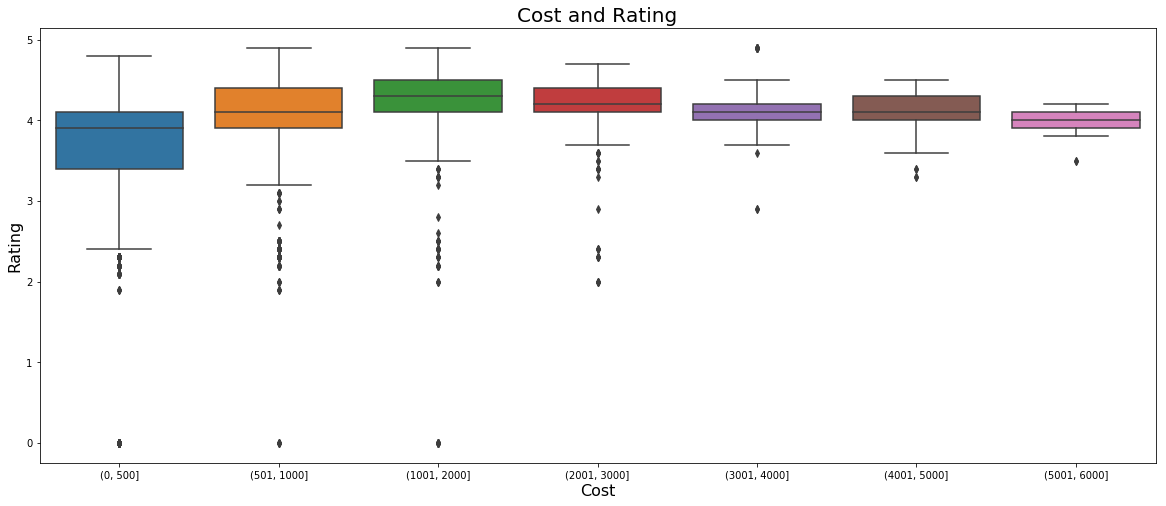

In [23]:
import seaborn as sns
bins = pd.IntervalIndex.from_tuples([(0, 500), (501, 1000), (1001, 2000), (2001, 3000), (3001, 4000), (4001, 5000), (5001, 6000)])
df_data_final['cost_cat'] = pd.cut(df_data_final['average_cost_for_two'], bins)
plt.figure(figsize=(20,8))
ax = sns.boxplot(x="cost_cat", y="aggregate_rating", data=df_data_final)
ax.set_xlabel('Cost', fontsize=16)
ax.set_ylabel('Rating', fontsize=16)
ax.set_title('Cost and Rating',fontsize=20)
plt.savefig("box.png")
df_data_final.drop('cost_cat', axis=1, inplace=True)

<br/>
<p style="font-size:20px"> Above box plot shows that ratings have increased will the price range of 1000-2000, but after that, the ratings have started declining</p>
<br/>
<p style="font-size:20px"> We shall be seeing if more features attract more customers? i.e, if more features that restaurant provides, lead to more number of customers</p>
<br/>

In [24]:
df_data_final['highlights']=df_data_final['highlights'].apply(lambda x: len(x.split(",")))

Text(0, 0.5, 'Number of Customers')

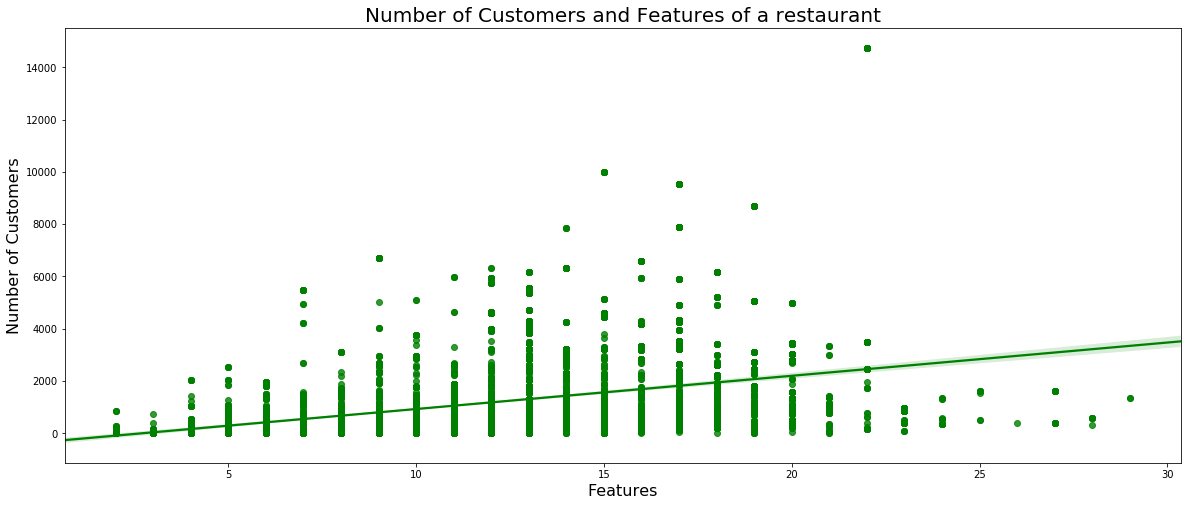

In [30]:
import seaborn as sns
plt.figure(figsize=(20, 8))
ax = sns.regplot(x='highlights', y='votes', data=df_data_final,color='green')
ax.set_title('Number of Customers and Features of a restaurant',fontsize=20) # add title
ax.set_xlabel('Features',fontsize=16)
ax.set_ylabel('Number of Customers',fontsize=16)

In [31]:
from scipy import stats
pearson_coef, p_value = stats.pearsonr(df_data_final['highlights'], df_data_final['votes'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.3610830067884935  with a P-value of P = 2.364567397697596e-174


<br/>
<br/>
<p style="font-size:30px"><b> Clustering locality on the basis of types of restaurants

In [55]:
types = set()
def func(x):
    if(type(x) == list):
        for y in x:
            types.add(y.strip())
_ = df_data_final['establishment'].str.split(',').apply(func)
column_names = list(types)

In [56]:
neighbor = pd.DataFrame(columns=column_names)
neighbor['neighborhood'] = df_data_final.groupby('locality').groups.keys()
neighbor = neighbor.set_index('neighborhood').fillna(0)
i=0
for i in range(0,len(df_data_final)):
    for x in types:
        if type(df_data_final.loc[i, 'establishment']) == str and x in df_data_final.loc[i, 'establishment']:
            neighbor.loc[df_data_final.loc[i, 'locality'], x] = neighbor.loc[df_data_final.loc[i, 'locality'], x]+1

In [57]:
kclusters = 4

delhi_grouped_clustering = neighbor

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [58]:
#neighborhood.drop('Cluster Labels', inplace=True, axis=1)
neighbor.insert(0, 'Cluster Labels', kmeans.labels_)
type_df = pd.merge(df_data_final[['locality','latitude', 'longitude']].groupby('locality').first(), neighbor, left_index=True, right_index=True)

In [59]:
states = folium.map.FeatureGroup()
labels = set(kmeans.labels_)
venues_map = folium.Map(location=[28.6139, 77.2090], zoom_start=11) # generate map centred around Delhi

states = folium.map.FeatureGroup()
i=0
j=0
for label in labels:
    group = type_df.groupby('Cluster Labels').get_group(label)
    for lat, lng, in zip(group.latitude, group.longitude):
        states.add_child(
            folium.CircleMarker(
                [lat, lng],
                radius=5, # define how big you want the circle markers to be
                color='yellow',
                fill=True,
                fill_color='blue',
                fill_opacity=0.6,
            )
        )
        i+=1
    colors = ['red', 'blue', 'green','purple']
    
    x = group.index
    i=0
    for lat, lng, in zip(group.latitude, group.longitude):
        states.add_child(
            folium.features.Marker(
                [lat, lng],
                popup= group.index[i],
                icon=folium.Icon(color=colors[j], icon='home')
            )
        )
        i+=1
    j+=1
# add incidents to map
venues_map.add_child(states)



venues_map

<br/>
<br/>
<p style="font-size:20px"> In the dense cluster(identifiable with red markers in map), let us identify which type of restaurants are dominant</p>
<br/>

In [66]:
df_cluster1=type_df.loc[type_df['Cluster Labels'] == 0 , type_df.columns[list(range(3, type_df.shape[1]))]]

In [67]:
df_cluster1['Total'] = df_cluster1.sum(axis=1)
df_cluster1['Total'].sum(axis=0)
df_cluster1

,,Microbrewery,Casual Dining,Lounge,Cocktail Bar,Pub,Café,Fine Dining,Bakery,Food Court,...,Beverage Shop,Sweet Shop,Dessert Parlour,Food Truck,Bhojanalya,Butcher Shop,Quick Bites,Bar,Kiosk,Total
locality,,,,,,,,,,,,,,,,,,,,,
Adchini,12,0,0,2,0,0,6,0,0,0,...,0,0,0,0,0,0,3,1,0,24
Alaknanda,4,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,8
Amar Colony,12,0,0,0,0,0,0,0,0,0,...,1,0,2,0,0,0,1,0,1,17
Anand Lok,10,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
Anand Vihar,15,0,0,0,0,0,12,0,0,0,...,1,1,0,1,0,0,0,0,0,30
Ardee City,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
Ashok Vihar Phase 1,8,0,0,0,0,0,0,0,2,0,...,0,0,1,0,0,2,2,0,1,16
Ashok Vihar Phase 2,18,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,14,0,0,36
Ashok Vihar Phase 3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,6


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


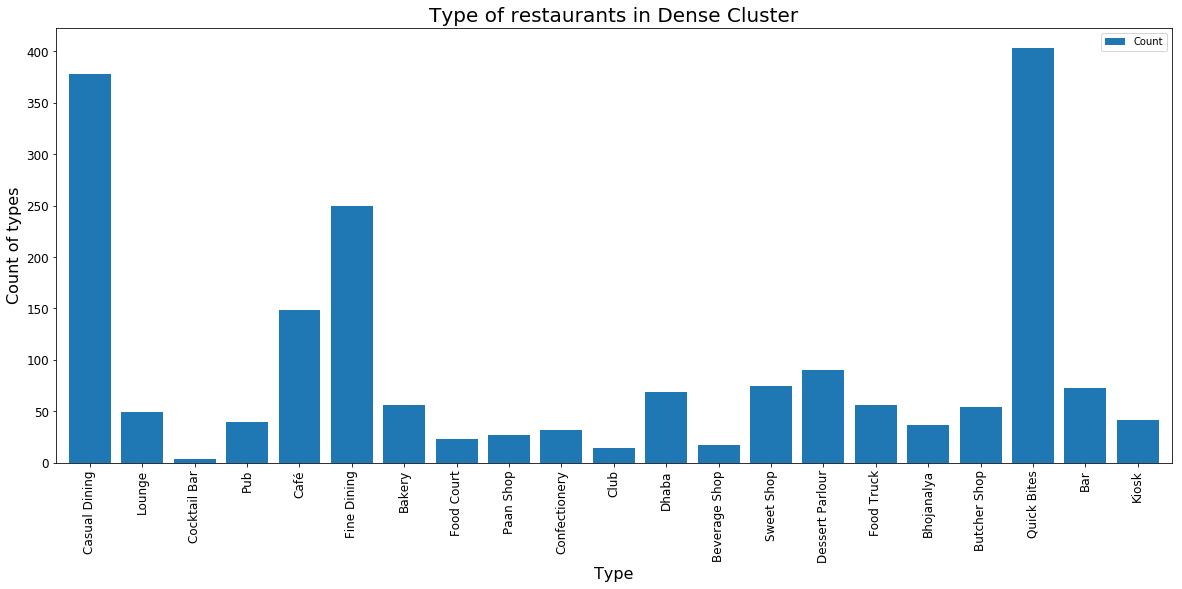

In [68]:
df_cluster1.drop(columns={"Total"},inplace=True)
df_cluster1_trans=df_cluster1.transpose()
df_cluster1_trans['Total'] = df_cluster1_trans.sum(axis=1)
df_cluster1_trans.reset_index(inplace=True)
df_cluster1_trans = df_cluster1_trans.loc[list(range(2,df_cluster1_trans.shape[1]))]
df_type=pd.DataFrame()
df_type['Type']=df_cluster1_trans['index']
df_type['Count'] = df_cluster1_trans['Total']
df_type.dropna(inplace=True)
df_type.set_index('Type',inplace=True)
df_type.plot(kind='bar',figsize=(20,8), width=0.8)

plt.xlabel('Type',fontsize=16) # add to x-label to the plot
plt.ylabel('Count of types',fontsize=16) # add y-label to the plot
plt.title('Type of restaurants in Dense Cluster',fontsize=20) # add title to the plot

ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

<p style="font-size:20px"> Now lets see in the densely populated cluster, which locality has the highest number of restaurants in Casual dining, Quick Bites and Fine Dining categories

In [69]:
df_cluster1_type_loc = pd.DataFrame()
df_cluster1.reset_index(inplace=True)
df_cluster_temp=df_cluster1
#df_cluster1.reset_index(inplace=True)
#df_cluster_temp.drop(columns={"level_0","index"},inplace=True)

df_cluster1_type_loc['locality']=df_cluster_temp['locality']
df_cluster1_type_loc['Casual Dining'] = df_cluster_temp['Casual Dining']
df_cluster1_type_loc['Quick Bites'] = df_cluster_temp['Quick Bites']
df_cluster1_type_loc['Fine Dining'] = df_cluster_temp['Fine Dining']
df_cluster1_type_loc['Total'] = df_cluster1_type_loc.sum(axis=1)
#df_cluster1_type_loc.set_index('locality',inplace=True)


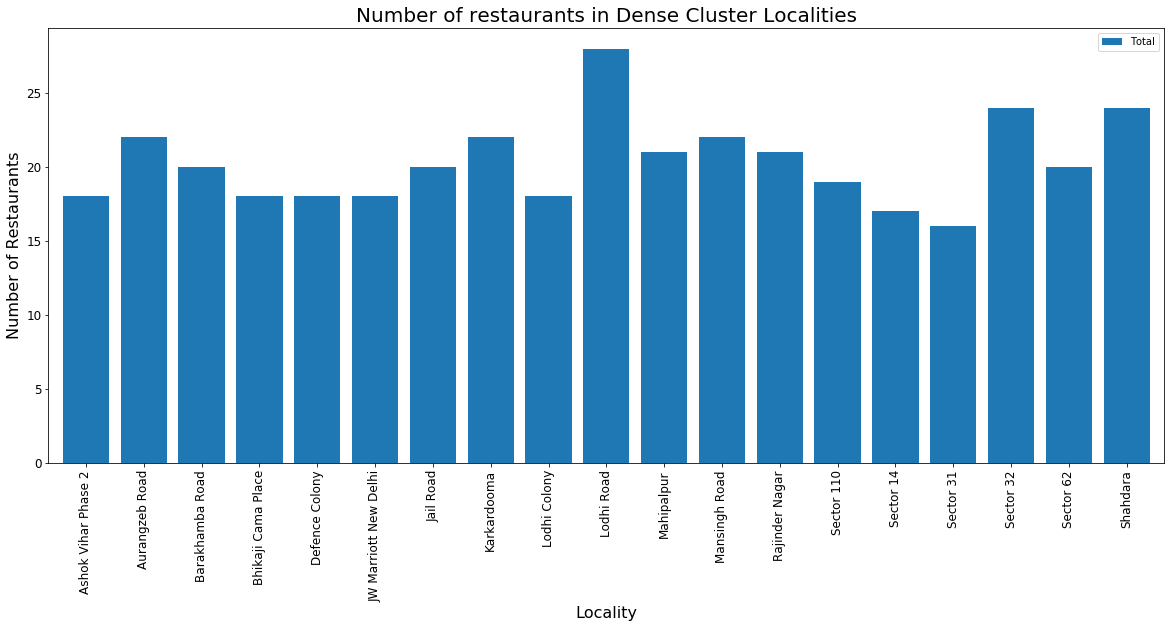

In [70]:

df_cluster_type_loc_bar=pd.DataFrame()
df_cluster_type_loc_bar['Locality']=df_cluster1_type_loc[df_cluster1_type_loc['Total']>15]['locality']
df_cluster_type_loc_bar['Total'] = df_cluster1_type_loc[df_cluster1_type_loc['Total']>15]['Total']
df_cluster_type_loc_bar.set_index('Locality',inplace=True)
df_cluster_type_loc_bar.plot(kind='bar',figsize=(20,8), width=0.8)

plt.xlabel('Locality',fontsize=16) # add to x-label to the plot
plt.ylabel('Number of Restaurants',fontsize=16) # add y-label to the plot
plt.title('Number of restaurants in Dense Cluster Localities',fontsize=20) # add title to the plot

ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()


<br/>

<p style="font-size:20px"> Therefore, from above chart, Lodhi Road, Shahdara, Sector 32,  looks like good places to open Casual Dining, Fine Dining or Quick Bites Restaurant.</p>

<br/>
    
<p style="font-size:20px"> Lets see the popular type of restaurants at each of these places


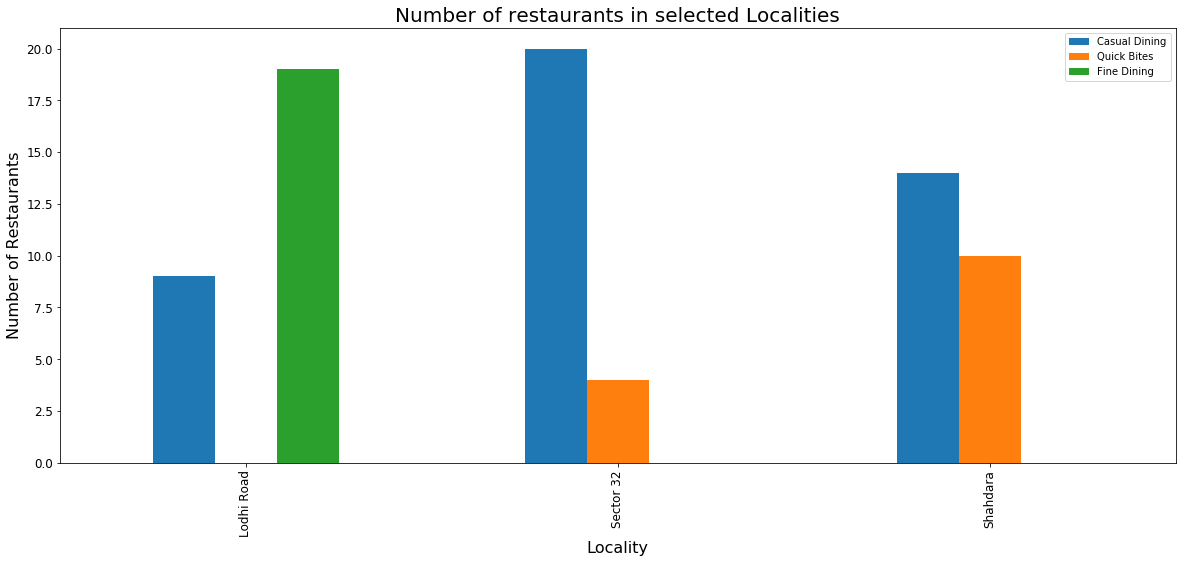

In [71]:
df_cluster1_type_loc_index=df_cluster1_type_loc.set_index('locality')
df_cluster1_type_loc_index=df_cluster1_type_loc_index[df_cluster1_type_loc_index['Total']>22]
df_cluster1_type_loc_index=df_cluster1_type_loc_index.drop(columns={"Total"})
df_cluster1_type_loc_index.plot(kind='bar',figsize=(20,8), width=0.5)

plt.xlabel('Locality',fontsize=16) # add to x-label to the plot
plt.ylabel('Number of Restaurants',fontsize=16) # add y-label to the plot
plt.title('Number of restaurants in selected Localities',fontsize=20) # add title to the plot

ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()


<br/>
<p style="font-size:20px;line-height:30px"> The graph, thus shows that Lodhi Road is ideal for Fine Dining, Sector 32 is better for Casual Dining, whereas, Shahdara is fine for casual dining and quick bites. From the ground knowledge, Shahdara has more residential area, a restaurant may work here but the restaurant should not be a high-end restaurant.
    </p>
<br/>


<br/>
<p style="font-size:20px"> Earlier, we saw that most of the restaurants are in and around Connaught place, which is Cluster 3. Let's analyse Cluster 3

In [72]:
df_cluster3=type_df.loc[type_df['Cluster Labels'] == 2, type_df.columns[list(range(4, type_df.shape[1]))]]
df_cluster3['Total'] = df_cluster3.sum(axis=1)
df_cluster3['Total']

locality
Connaught Place    435
Name: Total, dtype: int64

<p style="font-size:20px"> Cluster 3 has 435 total restuarants, while cluster 1 has 3878 restaurants. In deciding a place to open a restaurant, cluster 1 may be more helpful

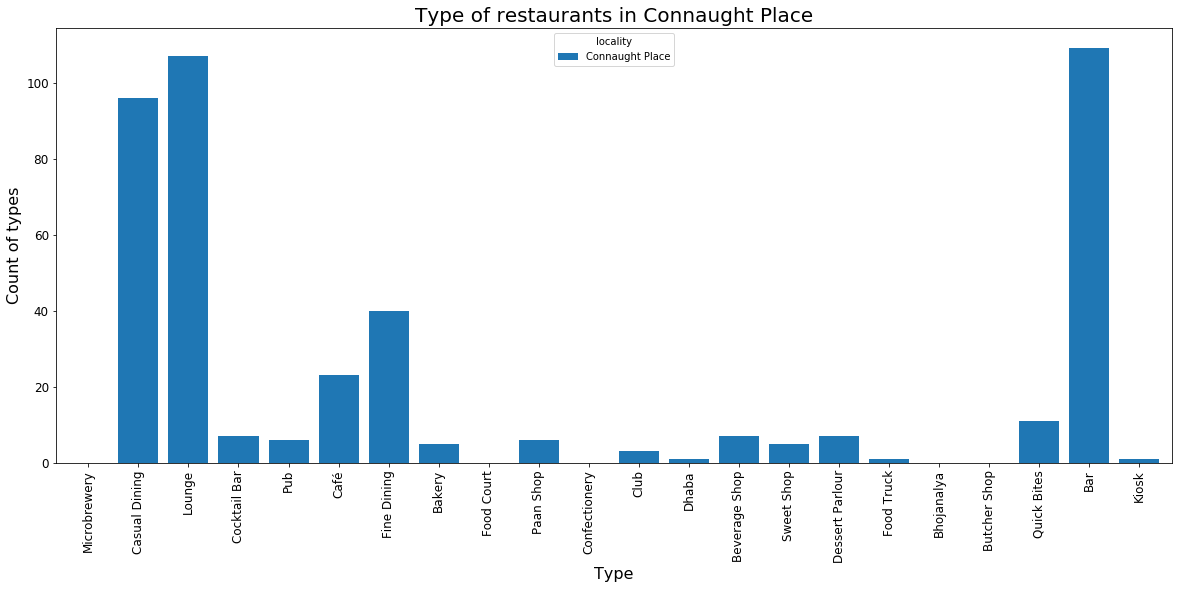

In [73]:
df_cluster3_trans=df_cluster3.drop(columns={"Total"}).transpose()
df_cluster3_trans.plot(kind='bar',figsize=(20,8), width=0.8)
plt.xlabel('Type',fontsize=16) # add to x-label to the plot
plt.ylabel('Count of types',fontsize=16) # add y-label to the plot
plt.title('Type of restaurants in Connaught Place',fontsize=20) # add title to the plot

ax=plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

<br/>
<p style="font-size:20px">Connaught Place has more number of Bars, Lounges and Casual Dinings than rest of the restaurant types</p>
 <br/>